Demo of mixuture of priors, cf MLaPP Sec.5.4.4

When we use a mixture of priors (with each prior being conjugate)

$
P(\theta) = \sum\limits_{\substack{k}} P(z=k) P(\theta|z=k)
$

where k is a hidden variable that represents the component of the mixture, $p(z=k)$ is the prior weight, and $p(\theta|z=k)$ the conjugate prior at component k.

The posterior can be written as 

$
P(\theta | D) = \dfrac{P(\theta, D)}{P(D)} = \dfrac{\sum\limits_{\substack{k}} P(\theta, D, z=k)}{P(D)} \\ \\ = \sum\limits_{\substack{k}} P(z=k|D) \hspace{3pt} P(\theta|D, z=k) \\ \\ = \sum\limits_{\substack{k}}  \underbrace{P(z=k|D)}_{\text{posterior weight for component k}} \hspace{3pt} \underbrace{P(\theta|D, z=k)}_{\text{conjugate posterior for component k}}
$

where $P(z=k|D)$ is the posterior weights

$
P(z=k|D) = \dfrac{P(D|z=k) P(z=k)}{\sum\limits_{\substack{k'}} P(D|z=k') P(z=k')}
$

where P(D|z=k) is the marginal:

$
P(D|z) = \dfrac{P(D,z)}{P(z)} = \dfrac{\int P(D,z,\theta)}{P(z)} = \dfrac{\int P(z) P(\theta|z) P(D|\theta, z) d\theta}{P(z)} = \int P(\theta|z) P(D|\theta, z) d\theta
$

- Below we use the following parameters to demonstrate: 

  a mixture of Beta priors: $a_1=b_1=10$, $a_2=30, b_2=10$, and 
  
  data: $x=20$ (head outcome) and $n=30$ (total trials)

In [41]:
import math
import scipy.stats
import scipy.special
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [67]:
def nCk(n, k):
    f = math.factorial
    return f(n) / (f(k) * f(n-k))


class MixBeta:
    
    """
    params = [{'a': 2, 'b': 2}, {'a': 3, 'b': 5}]
    prior_weights = np.ones(2)/float(k)
    mix_beta = MixBeta(2, params, prior_weights)
    """
    
    def __init__(self, k, params, prior_weights):
        
        self.k = k
        self.params = params.copy()
        self.prior_weights = prior_weights.copy()
        self.marginals = prior_weights.copy()

        
    def update(self, data):
        
        self.data = data
        n, x = data
        original_params = self.params.copy()
        for k in range(self.k):
            self.params[k] = {'a': original_params[k]['a'] + x,
                              'b': original_params[k]['b'] + n-x}
        for k in range(self.k):
            param = original_params[k]
            B = scipy.special.beta(x+param['a'], n-x+param['b']) / scipy.special.beta(param['a'], param['b'])
            self.marginals[k] = nCk(n, x) * B
            
        
    def computePosterior(self, t):
        
        posterior_weights = self.computePosteriorWeights()
        posteriors = self.prob(t)
        return np.sum(posterior_weights * posteriors)
    
    
    def prob(self, t):
                
        probs = []
        for k in range(self.k):
            param = self.params[k]
            beta = scipy.stats.beta(a=param['a'], b=param['b'])
            probs.append(beta.pdf(t))
        probs = np.array(probs)
        return np.sum(self.marginals * probs)

    
    def computePosteriorWeights(self):
        
        return self.marginals * self.prior_weights/np.sum(self.marginals * self.prior_weights)

    

In [68]:
params = [{'a': 20, 'b': 20}, {'a': 30, 'b': 10}]
prior_weights = np.ones(2)/float(2)
mix_beta = MixBeta(2, params, prior_weights)

tvalues = np.linspace(0, 1, 1000)


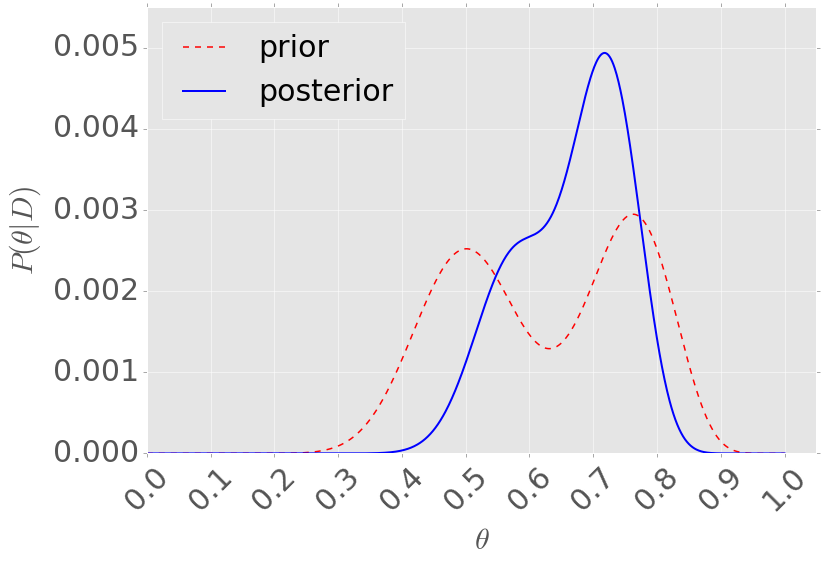

In [69]:
XMAX = 1.05
YMAX = 0.0055

FONTSIZE = 30
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12, 8))

prob_den = [mix_beta.prob(t) for t in tvalues]
prob_den /= np.sum(prob_den)
prior, = ax.plot(tvalues, prob_den, lw=1.5, linestyle='--', color='r')

data = (30, 20)
mix_beta.update(data)

prob_den = [mix_beta.prob(t) for t in tvalues]
prob_den /= np.sum(prob_den)
posterior, = ax.plot(tvalues, prob_den, lw=2, linestyle='-', color='b')

ax.set_xlabel(r'$\theta$', fontsize=FONTSIZE, labelpad=10)
ax.set_ylabel(r'$P(\theta|D)$', fontsize=FONTSIZE, labelpad=10)
ax.set_xlim(0, XMAX)
ax.set_ylim(0, YMAX)
ax.set_xticks(np.arange(0, XMAX, 0.1))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_rotation(45)

l = plt.legend([prior, posterior], ['prior', 'posterior'], loc='best', fontsize=FONTSIZE)
l.get_title().set_fontsize(FONTSIZE)


In [70]:
# Check the coefficient in Eq. (5.73)
B1 = scipy.special.beta(40,30)/scipy.special.beta(20,20)
B2 = scipy.special.beta(50,20)/scipy.special.beta(30,10)
print(B1/(B1+B2))
print(B2/(B1+B2))

0.345759667692
0.654240332308
